In [ ]:
# default_exp models.unet

# Unet Architecture

> A deep dive into Unet architecture in Pytorch.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# hide
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

Unet architecture from the [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) repository.

In [ ]:
# export
import functools
import torch.utils.model_zoo as model_zoo
from torchvision.models.resnet import ResNet
from torchvision.models.resnet import BasicBlock
from torchvision.models.resnet import Bottleneck
from pretrainedmodels.models.torchvision_models import pretrained_settings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
# export
class Model(nn.Module):

    def __init__(self):
        super().__init__()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

Custom `nn.Module` class with `kaiming_normal_` initialization. This class look into `self.modules` and if it's a `nn.BatchNorm2d` init with 1 the weights and 0 the biases.

In [ ]:
# export
class Conv2dReLU(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, use_batchnorm=True, **batchnorm_params):

        super().__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, bias=not (use_batchnorm)),
            nn.ReLU(inplace=True),
        ]

        if use_batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels, **batchnorm_params))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [ ]:
#show_doc(Conv2dReLU.__init__)

<h4 id="Conv2dReLU.__init__" class="doc_header"><code>Conv2dReLU.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Conv2dReLU.__init__</code>(**`in_channels`**, **`out_channels`**, **`kernel_size`**, **`padding`**=*`0`*, **`stride`**=*`1`*, **`use_batchnorm`**=*`True`*, **\*\*`batchnorm_params`**)

Initializes internal Module state, shared by both nn.Module and ScriptModule.

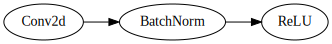

In [ ]:
gv('''Conv2d->BatchNorm->ReLU''')

In [ ]:
# export
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            Conv2dReLU(in_channels, out_channels, kernel_size=3,
                       padding=1, use_batchnorm=use_batchnorm),
            Conv2dReLU(out_channels, out_channels, kernel_size=3,
                       padding=1, use_batchnorm=use_batchnorm),
        )

    def forward(self, x):
        x, skip = x
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x

Up sample the inputs by a `scale_factor` of 2 with `'nearest'`, if a `skip` connection is provided then concatenates with the inputs and then do a double `Conv2dReLU`.

In [ ]:
# export
class CenterBlock(DecoderBlock):

    def forward(self, x):
        return self.block(x)

A double `Conv2dReLU` without up sampling.

In [ ]:
# export
class EncoderDecoder(Model):

    def __init__(self, encoder, decoder, activation):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        if callable(activation) or activation is None:
            self.activation = activation
        elif activation == 'softmax':
            self.activation = nn.Softmax(dim=1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(
                'Activation should be "sigmoid"/"softmax"/callable/None')

    def forward(self, x):
        """Sequentially pass `x` trough model's `encoder` and `decoder` (return logits!)"""
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def predict(self, x):
        """
        Inference method. Switch model to `eval` mode, call `.forward(x)`
        and apply activation function (if activation is not `None`) with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        with torch.no_grad():
            x = self.forward(x)
            if self.activation:
                x = self.activation(x)

        return x

In [ ]:
#show_doc(EncoderDecoder.__init__)

<h4 id="EncoderDecoder.__init__" class="doc_header"><code>EncoderDecoder.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>EncoderDecoder.__init__</code>(**`encoder`**, **`decoder`**, **`activation`**)

Initializes internal Module state, shared by both nn.Module and ScriptModule.

In [ ]:
#show_doc(EncoderDecoder.forward)

<h4 id="EncoderDecoder.forward" class="doc_header"><code>EncoderDecoder.forward</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>EncoderDecoder.forward</code>(**`x`**)

Sequentially pass `x` trough model's `encoder` and `decoder` (return logits!)

In [ ]:
#show_doc(EncoderDecoder.predict)

<h4 id="EncoderDecoder.predict" class="doc_header"><code>EncoderDecoder.predict</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>EncoderDecoder.predict</code>(**`x`**)

Inference method. Switch model to `eval` mode, call `.forward(x)`
and apply activation function (if activation is not `None`) with `torch.no_grad()`

Args:
    x: 4D torch tensor with shape (batch_size, channels, height, width)

Return:
    prediction: 4D torch tensor with shape (batch_size, classes, height, width)

In [ ]:
# export
class UnetDecoder(Model):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            use_batchnorm=True,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = CenterBlock(
                channels, channels, use_batchnorm=use_batchnorm)
        else:
            self.center = None

        in_channels = self.compute_channels(encoder_channels, decoder_channels)
        out_channels = decoder_channels

        self.layer1 = DecoderBlock(
            in_channels[0], out_channels[0], use_batchnorm=use_batchnorm)
        self.layer2 = DecoderBlock(
            in_channels[1], out_channels[1], use_batchnorm=use_batchnorm)
        self.layer3 = DecoderBlock(
            in_channels[2], out_channels[2], use_batchnorm=use_batchnorm)
        self.layer4 = DecoderBlock(
            in_channels[3], out_channels[3], use_batchnorm=use_batchnorm)
        self.layer5 = DecoderBlock(
            in_channels[4], out_channels[4], use_batchnorm=use_batchnorm)
        self.final_conv = nn.Conv2d(
            out_channels[4], final_channels, kernel_size=(1, 1))

        self.initialize()

    def compute_channels(self, encoder_channels, decoder_channels):
        channels = [
            encoder_channels[0] + encoder_channels[1],
            encoder_channels[2] + decoder_channels[0],
            encoder_channels[3] + decoder_channels[1],
            encoder_channels[4] + decoder_channels[2],
            0 + decoder_channels[3],
        ]
        return channels

    def forward(self, x):
        encoder_head = x[0]
        skips = x[1:]

        if self.center:
            encoder_head = self.center(encoder_head)

        x = self.layer1([encoder_head, skips[0]])
        x = self.layer2([x, skips[1]])
        x = self.layer3([x, skips[2]])
        x = self.layer4([x, skips[3]])
        x = self.layer5([x, None])
        x = self.final_conv(x)

        return x

Decoder part of a Unet.

In [ ]:
# export
class ResNetEncoder(ResNet):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pretrained = False
        del self.fc

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)

        x1 = self.maxpool(x0)
        x1 = self.layer1(x1)

        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return [x4, x3, x2, x1, x0]

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop('fc.bias')
        state_dict.pop('fc.weight')
        super().load_state_dict(state_dict, **kwargs)

Encoder part of a Unet.

In [ ]:
# export
resnet_encoders = {
    'resnet18': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet18'],
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [2, 2, 2, 2],
        },
    },

    'resnet34': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet34'],
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet50': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet50'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet101': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet101'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 23, 3],
        },
    },

    'resnet152': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet152'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 8, 36, 3],
        },
    },
}

encoders = {}
encoders.update(resnet_encoders)

In [ ]:
# export
def preprocess_input(x, mean=None, std=None, input_space='RGB', input_range=None, **kwargs):
    """Preprocessing the `x` inputs with normalization."""
    if input_space == 'BGR':
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

In [ ]:
# export
def get_encoder(name, encoder_weights=None):
    Encoder = encoders[name]['encoder']
    encoder = Encoder(**encoders[name]['params'])
    encoder.out_shapes = encoders[name]['out_shapes']

    if encoder_weights is not None:
        settings = encoders[name]['pretrained_settings'][encoder_weights]
        encoder.load_state_dict(model_zoo.load_url(settings['url']))

    return encoder


def get_encoder_names():
    return list(encoders.keys())


def get_preprocessing_fn(encoder_name, pretrained='imagenet'):
    settings = encoders[encoder_name]['pretrained_settings']

    if pretrained not in settings.keys():
        raise ValueError(
            'Avaliable pretrained options {}'.format(settings.keys()))

    input_space = settings[pretrained].get('input_space')
    input_range = settings[pretrained].get('input_range')
    mean = settings[pretrained].get('mean')
    std = settings[pretrained].get('std')

    return functools.partial(preprocess_input, mean=mean, std=std, input_space=input_space, input_range=input_range)

In [ ]:
# export
class Unet(EncoderDecoder):
    """Unet_ is a fully convolution neural network for image semantic segmentation

    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        activation: activation function used in ``.predict(x)`` method for inference.
            One of [``sigmoid``, ``softmax``, callable, None]
        center: if ``True`` add ``Conv2dReLU`` block on encoder head (useful for VGG models)

    Returns:
        ``torch.nn.Module``: **Unet**

    Paper:
    https://arxiv.org/pdf/1505.04597

    """

    def __init__(self,
            encoder_name='resnet34',
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            classes=1,
            activation='sigmoid',
            center=False,  # usefull for VGG models
    ):
        encoder = get_encoder(
            encoder_name,
            encoder_weights=encoder_weights
        )

        decoder = UnetDecoder(
            encoder_channels=encoder.out_shapes,
            decoder_channels=decoder_channels,
            final_channels=classes,
            use_batchnorm=decoder_use_batchnorm,
            center=center,
        )

        super().__init__(encoder, decoder, activation)

        self.name = 'u-{}'.format(encoder_name)

In [ ]:
#show_doc(Unet.__init__)

<h4 id="Unet.__init__" class="doc_header"><code>Unet.__init__</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>Unet.__init__</code>(**`encoder_name`**=*`'resnet34'`*, **`encoder_weights`**=*`'imagenet'`*, **`decoder_use_batchnorm`**=*`True`*, **`decoder_channels`**=*`(256, 128, 64, 32, 16)`*, **`classes`**=*`1`*, **`activation`**=*`'sigmoid'`*, **`center`**=*`False`*)

Initializes internal Module state, shared by both nn.Module and ScriptModule.

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_models.dls.ipynb.
Converted 04_model.metrics.ipynb.
Converted 05_models.unet.ipynb.
Converted 06_models.model.ipynb.
Converted index.ipynb.
